In [4]:
pip uninstall   cupy-cuda11x

Found existing installation: cupy-cuda11x 13.4.1
Uninstalling cupy-cuda11x-13.4.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/detail/array_utils.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/detail/fast_modulo_division.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/detail/launcher/cuda_driver.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/detail/launcher/cuda_runtime.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/detail/mdspan_utils.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/device/device_transform.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/device/dispatch/dispatch_for_each_in_extents.cuh
    /usr/local/lib/python3.11/dist-packages/cupy/_core/include/cupy/_cccl/cub/cub/device/dispatch/dispatch

In [1]:
# ✅ Install RAPIDS AI (GPU support)
!pip install --upgrade --no-cache-dir nvidia-pyindex
!pip install --upgrade --no-cache-dir cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [12]:
# ✅ Imports
import cudf
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.linear_model import LogisticRegression as cuLogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split



In [14]:

# ✅ Load and Label Data
fake = cudf.read_csv('/content/Fake.csv')
real = cudf.read_csv('/content/True.csv')
fake['label'] = 0
real['label'] = 1

In [15]:
# ✅ Split using pandas to avoid object dtype errors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# ✅ Convert to cuDF AFTER splitting
X_train_cu = cudf.Series(X_train.tolist())
X_test_cu = cudf.Series(X_test.tolist())
y_train_cu = cudf.Series(y_train.values)
y_test_cu = cudf.Series(y_test.values)


In [17]:

# ✅ TF-IDF Vectorization on GPU
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train_cu)
X_test_vec = vectorizer.transform(X_test_cu)

In [18]:

# ✅ Train cuML Model
model = cuLogisticRegression()
model.fit(X_train_vec, y_train_cu)



LogisticRegression()

In [21]:
# ✅ Predict and Evaluate
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test_cu.to_numpy(), y_pred.get())


print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9898


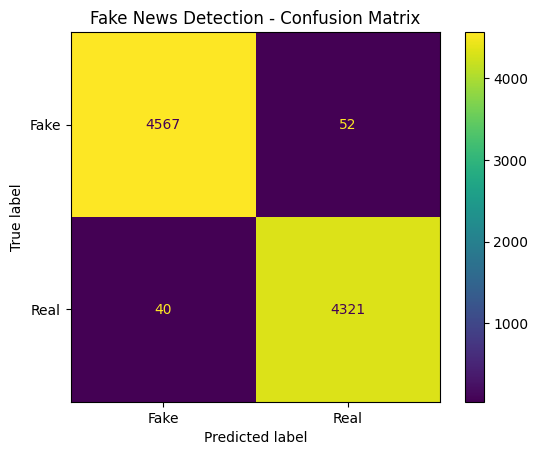

In [31]:
# Convert cudf.Series to NumPy arrays explicitly using .get()
y_test_cu_numpy = y_test_cu.to_numpy()  # This is correct

# Explicitly convert cudf Series to NumPy using .get()
y_pred_numpy = y_pred.get()

# Now call ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_cu_numpy, y_pred_numpy, display_labels=["Fake", "Real"])
plt.title("Fake News Detection - Confusion Matrix")
plt.show()


In [32]:

# ✅ Save Model and Vectorizer
os.makedirs("model", exist_ok=True)
joblib.dump(vectorizer, "model/tfidf_vectorizer.joblib")
joblib.dump(model, "model/fake_news_model.joblib")

['model/fake_news_model.joblib']